In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Dir {dirname} has {len(_)} dirs & {len(filenames)} files")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Dir /kaggle/input has 1 dirs & 0 files
Dir /kaggle/input/fashion-pattern-images has 1 dirs & 0 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images has 19 dirs & 0 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images/tropical has 0 dirs & 564 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images/houndstooth has 0 dirs & 561 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images/dot has 0 dirs & 611 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images/snow_flake has 0 dirs & 584 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images/camouflage has 0 dirs & 569 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images/gradient has 0 dirs & 561 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images/paisley has 0 dirs & 561 files
Dir /kaggle/input/fashion-pattern-images/fashion-pattern-images/zigzag has 0 dirs & 570 files
Dir /kaggle/input/fashion-pattern-images/fashi

In [2]:
import random
import os
from pathlib import Path
from PIL import Image

In [3]:
dataset_img_path = Path("/kaggle/input/fashion-pattern-images/fashion-pattern-images")

1000 750
leopard


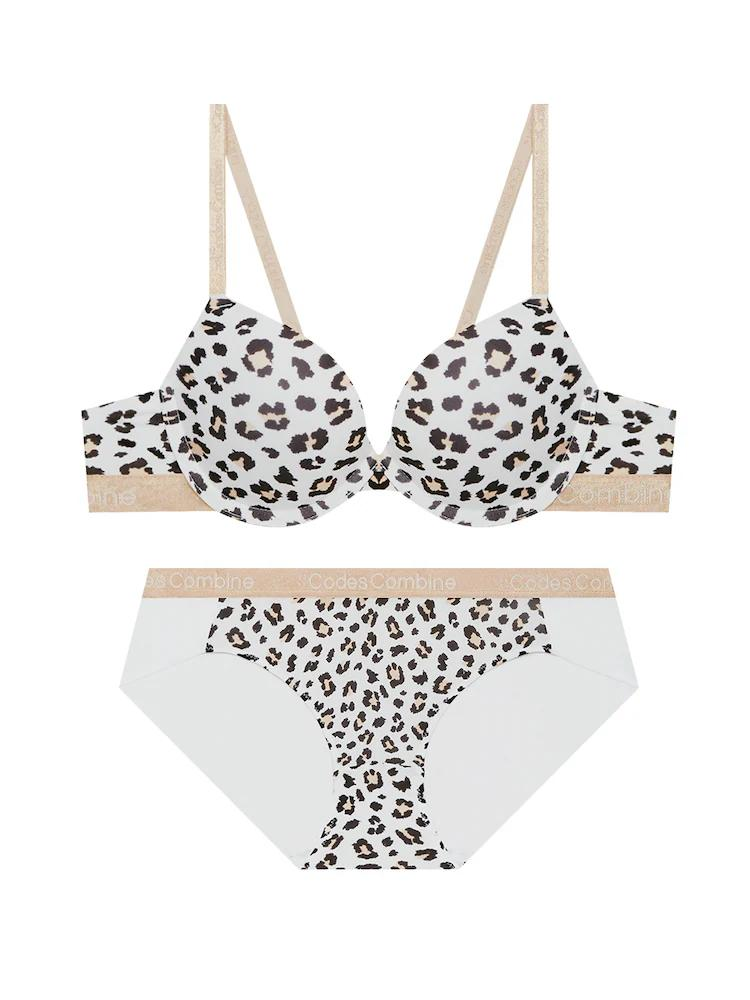

In [4]:
image_list = list(dataset_img_path.glob("*/*.jpg"))

random_img = random.choice(image_list)

random_img_class = random_img.parent.stem

img = Image.open(random_img)
print(img.height,img.width)
print(random_img_class)
img

In [5]:
from torch.utils.data import DataLoader,random_split
from torchvision import datasets,transforms
import torchvision.models as models
import timm
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping

In [6]:
transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]
)

In [7]:
img_dataset = datasets.ImageFolder(dataset_img_path,transform=transform)
train_dataset,test_dataset = random_split(img_dataset,[0.8,0.2])
train_dataloader = DataLoader(train_dataset,
                        batch_size=64,
                              shuffle= True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=True)

(-0.5, 127.5, 127.5, -0.5)

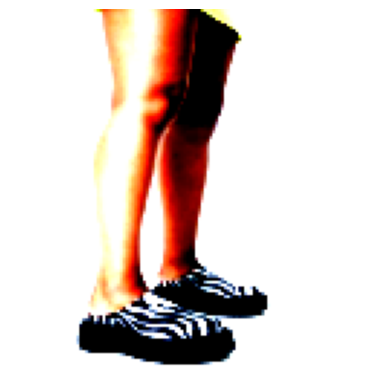

In [8]:
img,label = train_dataset[9]

plt.imshow(img.permute(1,2,0))
plt.axis(False)

In [9]:
import torch.nn as nn
import torch
from sklearn.metrics import confusion_matrix,classification_report

In [10]:
torch.cuda.empty_cache()

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn
):

  train_loss, train_acc = 0,0
  for batch,(X,Y) in enumerate(dataloader):
    X = X.to(device)
    Y = Y.to(device)
    model.train()
    pred = model(X)
    loss = loss_fn(pred,Y)
    train_loss+=loss.item()
    acc = accuracy_fn(Y,pred.argmax(dim=1))
    train_acc+=acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss,train_acc

In [14]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn
):

  test_loss, test_acc = 0,0
  for batch,(X,Y) in enumerate(dataloader):
    with torch.inference_mode():
      X = X.to(device)
      Y = Y.to(device)
      model.eval()
      pred = model(X)
      loss = loss_fn(pred,Y)
      test_loss+=loss.item()
      acc = accuracy_fn(Y,pred.argmax(dim=1))
      test_acc+=acc

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)

  return test_loss,test_acc

In [15]:
#model = PatternModel().to(device)
'''model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 19)'''
model = timm.create_model("rexnet_150",pretrained=True,num_classes=19)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0001)

epochs = 10
train_loss_list,test_loss_list = [],[]
train_acc_list,test_acc_list = [],[]

for epoch in tqdm(range(epochs)):
  loss_t,acc_t = train_step(model,
                        train_dataloader,
                        loss_fn,
                        optimizer,
                        accuracy_fn)
  print(f"Train loss {loss_t:.5f} | Train Acc {acc_t:.2f}%")
  train_loss_list.append(loss_t)
  train_acc_list.append(acc_t)

  val_loss,val_acc = test_step(model,
                        test_dataloader,
                        loss_fn,
                        accuracy_fn)
  print(f"Test loss {val_loss:.5f} | Test Acc {val_acc:.2f}%")
  test_loss_list.append(val_loss)
  test_acc_list.append(val_acc)


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss 2.71836 | Train Acc 27.28%


 10%|█         | 1/10 [03:03<27:27, 183.05s/it]

Test loss 1.62006 | Test Acc 52.23%
Train loss 1.25519 | Train Acc 62.26%


 20%|██        | 2/10 [05:10<20:02, 150.26s/it]

Test loss 1.17586 | Test Acc 63.50%
Train loss 0.81084 | Train Acc 75.06%


 30%|███       | 3/10 [07:17<16:19, 139.88s/it]

Test loss 1.08557 | Test Acc 67.46%
Train loss 0.55972 | Train Acc 81.93%


 40%|████      | 4/10 [09:24<13:28, 134.79s/it]

Test loss 0.97454 | Test Acc 71.24%
Train loss 0.37224 | Train Acc 88.33%


 50%|█████     | 5/10 [11:32<11:01, 132.38s/it]

Test loss 0.92198 | Test Acc 73.88%
Train loss 0.24980 | Train Acc 92.56%


 60%|██████    | 6/10 [13:43<08:46, 131.70s/it]

Test loss 0.95983 | Test Acc 72.62%
Train loss 0.18279 | Train Acc 94.67%


 70%|███████   | 7/10 [15:52<06:32, 130.77s/it]

Test loss 0.97869 | Test Acc 74.99%
Train loss 0.13038 | Train Acc 96.11%


 80%|████████  | 8/10 [18:01<04:20, 130.39s/it]

Test loss 0.94962 | Test Acc 74.72%
Train loss 0.09760 | Train Acc 97.30%


 90%|█████████ | 9/10 [20:09<02:09, 129.55s/it]

Test loss 0.94732 | Test Acc 75.80%
Train loss 0.08698 | Train Acc 97.62%


100%|██████████| 10/10 [22:19<00:00, 133.95s/it]

Test loss 1.00591 | Test Acc 73.90%


Text(0.5, 1.0, 'Acc')

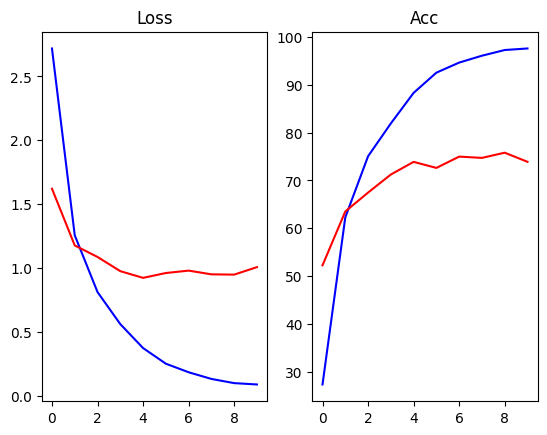

In [16]:
plt.subplot(1,2,1)
plt.plot(range(len(train_loss_list)),train_loss_list,c="b")
plt.plot(range(len(test_loss_list)),test_loss_list,c="r")
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(range(len(train_acc_list)),train_acc_list,c="b")
plt.plot(range(len(test_acc_list)),test_acc_list,c="r")
plt.title("Acc")

In [29]:
model(img.unsqueeze(dim=0).to(device)).argmax(dim=1).dtype

torch.int64

In [45]:
X_test = torch.ones([len(test_dataset),3,128,128],dtype=torch.float32)
Y_test = torch.ones([len(test_dataset)],dtype=torch.long)
for i in range(len(test_dataset)):
    img,label = test_dataset[i]
    X_test[i] = img
    Y_test[i] = label

In [49]:
torch.cuda.empty_cache()

In [51]:
with torch.inference_mode():
    model.eval()
    Y_pred = model(X_test.to(device))
    Y_pred = Y_pred.argmax(dim=1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.60 GiB. GPU 0 has a total capacty of 14.75 GiB of which 755.06 MiB is free. Process 2417 has 14.01 GiB memory in use. Of the allocated memory 12.91 GiB is allocated by PyTorch, and 972.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [52]:
Y_pred = Y_pred.detach().to("cpu")
Y_pred.shape,Y_test.shape

(torch.Size([2179]), torch.Size([2179]))

In [54]:
print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))

[[ 94   0   6   0   1   3   0   1   1   0   0   1   0   0   0   0   1   0
    1]
 [  0 104   0   0   3   1   0   1   1   0   3   2   1   5   1   0   0   1
    0]
 [ 11   0  76   7   1   0   2   0   6   0   2   3   0   1   0   4   0   0
    2]
 [  1   0   1 100   4   0   0   0   4   3   0   4   0   0   2   0   1   0
    1]
 [  1   4   2   5  66   1   0  10   1   6   0   3   8   1   3   2   3   0
    0]
 [  6   1   6   3   5  48   1   3   3   1   1   0   8   2   2   1   2   0
    7]
 [  0   1   0   0   0   0  95   3   0   0   2   1   0   0   0   1   1   1
    1]
 [  0   3   0   3  12   4   0  72   0   0   5   0   4   1   0   1  11   2
    1]
 [  4   2   8   4   0   0   0   0  92   1   0   0   0   1   1   3   0   0
    3]
 [  0   6   0   5   7   1   2   0   0 101   3   0   0   5   1   0   0   0
    0]
 [  0   1   0   1   1   1   2  12   0   2  85   3   2   0   0   1   0   4
    2]
 [  1   2   1   2   1   0   7   3   1   3   4  94   0   0   0   6   0   1
    0]
 [  0   3   0   0  10   3   

tensor(10) tensor(10)


(-0.5, 127.5, 127.5, -0.5)

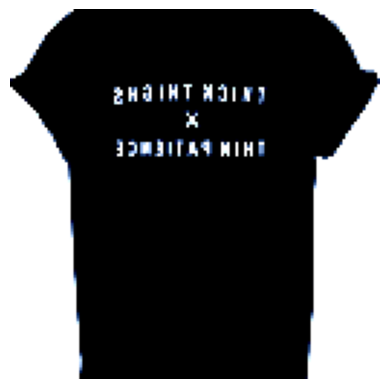

In [56]:
plt.imshow(X_test[0].permute(1,2,0))
print(Y_pred[0],Y_test[0])
plt.axis(False)

In [57]:

model1 = models.resnet18(pretrained=True)
model1.fc = nn.Linear(model1.fc.in_features, 19)
'''model = timm.create_model("rexnet_150",pretrained=True,num_classes=19)'''
model1 = model1.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),
                             lr=0.0001)

epochs = 10
train_loss_list_1,test_loss_list_1 = [],[]
train_acc_list_1,test_acc_list_1 = [],[]

for epoch in tqdm(range(epochs)):
  loss_t,acc_t = train_step(model1,
                        train_dataloader,
                        loss_fn,
                        optimizer,
                        accuracy_fn)
  print(f"Train loss {loss_t:.5f} | Train Acc {acc_t:.2f}%")
  train_loss_list_1.append(loss_t)
  train_acc_list_1.append(acc_t)

  val_loss,val_acc = test_step(model1,
                        test_dataloader,
                        loss_fn,
                        accuracy_fn)
  print(f"Test loss {val_loss:.5f} | Test Acc {val_acc:.2f}%")
  test_loss_list_1.append(val_loss)
  test_acc_list_1.append(val_acc)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s] 
  0%|          | 0/10 [00:00<?, ?it/s]

Train loss 1.73137 | Train Acc 48.73%


 10%|█         | 1/10 [02:15<20:16, 135.17s/it]

Test loss 1.21261 | Test Acc 63.72%
Train loss 0.92975 | Train Acc 71.58%


 20%|██        | 2/10 [04:18<17:07, 128.47s/it]

Test loss 1.08862 | Test Acc 65.91%
Train loss 0.61954 | Train Acc 81.87%


 30%|███       | 3/10 [06:22<14:42, 126.09s/it]

Test loss 0.96210 | Test Acc 70.65%
Train loss 0.41047 | Train Acc 88.20%


 40%|████      | 4/10 [08:25<12:30, 125.12s/it]

Test loss 1.00148 | Test Acc 70.16%
Train loss 0.27816 | Train Acc 92.14%


 50%|█████     | 5/10 [10:30<10:24, 124.96s/it]

Test loss 1.03459 | Test Acc 70.65%
Train loss 0.19448 | Train Acc 95.25%


 60%|██████    | 6/10 [12:35<08:20, 125.10s/it]

Test loss 1.02619 | Test Acc 71.65%
Train loss 0.13453 | Train Acc 96.69%


 70%|███████   | 7/10 [14:40<06:14, 124.87s/it]

Test loss 1.02646 | Test Acc 72.01%
Train loss 0.11493 | Train Acc 97.35%


 80%|████████  | 8/10 [16:46<04:10, 125.20s/it]

Test loss 1.11612 | Test Acc 72.26%
Train loss 0.09680 | Train Acc 97.53%


 90%|█████████ | 9/10 [18:52<02:05, 125.48s/it]

Test loss 1.10318 | Test Acc 71.32%
Train loss 0.07004 | Train Acc 98.45%


100%|██████████| 10/10 [20:58<00:00, 125.82s/it]

Test loss 1.16735 | Test Acc 70.65%
